## Importing libraries 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Frame proccessor (main function)

In [2]:
def frame_processor(image):
    """
    Process the input frame to detect lane lines.
    Parameters:
    	image: image of a road where one wants to detect lane lines
    	(we will be passing frames of video to this function)
    """
    # convert the RGB image to Gray scale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # applying gaussian Blur which removes noise from the image 
    # and focuses on our region of interest
    # size of gaussian kernel
    kernel_size = 5
    # Applying gaussian blur to remove noise from the frames
    blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
    # first threshold for the hysteresis procedure
    low_t = 50
    # second threshold for the hysteresis procedure 
    high_t = 150
    # applying canny edge detection and save edges in a variable
    edges = cv2.Canny(blur, low_t, high_t)  # THIS IS RETURNING NONE
    # since we are getting too many edges from our image, we apply 
    # a mask polygon to only focus on the road
    # Will explain Region selection in detail in further steps
    region = region_selection(edges)
    # Applying hough transform to get straight lines from our image 
    # and find the lane lines
    # Will explain Hough Transform in detail in further steps
    hough = hough_transform(region)
    #left_fit, right_fit = detect_lanes_poly(region)
    #result = draw_lanes(region, left_fit, right_fit)
    #lastly we draw the lines on our resulting frame and return it as output 
    result = draw_lane_lines(image, lane_lines(image, hough))
    if result is not None:
        return result
    else:
        return image

## 1. Region selection

In [3]:
def region_selection(image):
	"""
	Determine and cut the region of interest in the input image.
	Parameters:
		image: we pass here the output from canny where we have 
		identified edges in the frame
	"""
	# create an array of the same size as of the input image 
	mask = np.zeros_like(image) 
	# if you pass an image with more then one channel
	if len(image.shape) > 2:
		channel_count = image.shape[2]
		ignore_mask_color = (255,) * channel_count
	# our image only has one channel so it will go under "else"
	else:
		# color of the mask polygon (white)
		ignore_mask_color = 255
	# creating a polygon to focus only on the road in the picture
	# we have created this polygon in accordance to how the camera was placed
	rows, cols = image.shape[:2]
	bottom_left = [cols * 0.0, rows * 1]
	top_left	 = [cols * 0.4, rows * 0.49]
	bottom_right = [cols * 1, rows * 1]
	top_right = [cols * 0.6, rows * 0.49]
	vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
	# filling the polygon with white color and generating the final mask
	cv2.fillPoly(mask, vertices, ignore_mask_color)
	# performing Bitwise AND on the input image and mask to get only the edges on the road
	masked_image = cv2.bitwise_and(image, mask)
	return masked_image

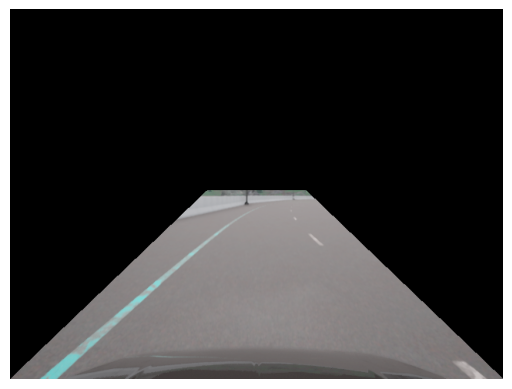

In [46]:
image = cv2.imread(r"G:\carla_data_T4_original\CCW2\137.png")
#image = cv2.imread(r"G:\carla_data_original\LT1\0.png")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel_size = 5
# Applying gaussian blur to remove noise from the frames
blur = cv2.GaussianBlur(image_gray, (kernel_size, kernel_size), 0)
low_t = 50
# second threshold for the hysteresis procedure 
high_t = 125
# applying canny edge detection and save edges in a variable
edges = cv2.Canny(blur, low_t, high_t)
processed_image = region_selection(image)
#processed_image = region_selection(edges)

# Assuming 'image' is your NumPy array
plt.imshow(processed_image)  # Use cmap='gray' for grayscale images
plt.axis('off')  # Hide the axis for better visualization
plt.show()

## 2. Hough transformation

In [24]:
def hough_transform(image):
	"""
	Determine and cut the region of interest in the input image.
	Parameter:
		image: grayscale image which should be an output from the edge detector
	"""
	# Distance resolution of the accumulator in pixels.
	rho = 1			
	# Angle resolution of the accumulator in radians.
	theta = np.pi/180
	# Only lines that are greater than threshold will be returned.
	threshold = 10	
	# Line segments shorter than that are rejected.
	minLineLength = 10
	# Maximum allowed gap between points on the same line to link them
	maxLineGap = 250	
	# function returns an array containing dimensions of straight lines 
	# appearing in the input image
	return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
						minLineLength = minLineLength, maxLineGap = maxLineGap)

In [25]:
def average_slope_intercept(lines):
	"""
	Find the slope and intercept of the left and right lanes of each image.
	Parameters:
		lines: output from Hough Transform
	"""
	left_lines = [] #(slope, intercept)
	left_weights = [] #(length,)
	right_lines = [] #(slope, intercept)
	right_weights = [] #(length,)
	
	for line in lines:
		for x1, y1, x2, y2 in line:
			if x1 == x2:
				continue
			# calculating slope of a line
			slope = (y2 - y1) / (x2 - x1)
			# calculating intercept of a line
			intercept = y1 - (slope * x1)
			# calculating length of a line
			length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
			# slope of left lane is negative and for right lane slope is positive
			if slope < 0:
				left_lines.append((slope, intercept))
				left_weights.append((length))
			else:
				right_lines.append((slope, intercept))
				right_weights.append((length))
	# 
	left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
	right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
	return left_lane, right_lane

def pixel_points(y1, y2, line):
	"""
	Converts the slope and intercept of each line into pixel points.
		Parameters:
			y1: y-value of the line's starting point.
			y2: y-value of the line's end point.
			line: The slope and intercept of the line.
	"""
	if line is None:
		return None
	slope, intercept = line
	x1 = int((y1 - intercept)/slope)
	x2 = int((y2 - intercept)/slope)
	y1 = int(y1)
	y2 = int(y2)
	return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
	"""
	Create full lenght lines from pixel points.
		Parameters:
			image: The input test image.
			lines: The output lines from Hough Transform.
	"""
	left_lane, right_lane = average_slope_intercept(lines)
	y1 = image.shape[0]
	y2 = y1 * 0.6
	left_line = pixel_points(y1, y2, left_lane)
	right_line = pixel_points(y1, y2, right_lane)
	return left_line, right_line

	
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
	"""
	Draw lines onto the input image.
		Parameters:
			image: The input test image (video frame in our case).
			lines: The output lines from Hough Transform.
			color (Default = red): Line color.
			thickness (Default = 12): Line thickness. 
	"""
	line_image = np.zeros_like(image)
	for line in lines:
		if line is not None:
			cv2.line(line_image, *line, color, thickness)
	return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

## 2a. (Alternate) Polynomial fitting

In [26]:
i = 0

## Implmentation and plotting

0.png


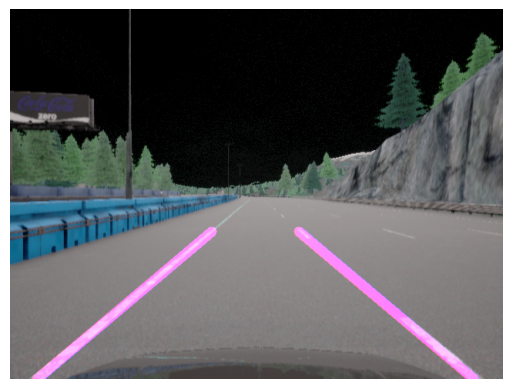

In [27]:
image = cv2.imread(f"G:\carla_data_T4_uncropped\CCW2\{i}.png")
print(f"{i}.png")
i += 1
#image = cv2.imread(f"G:\carla_data_T4\CCW2\114.png")
#image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
processed_image = frame_processor(image)
cropped_image = region_selection(processed_image)

# Assuming 'image' is your NumPy array
#plt.imshow(cropped_image)
plt.imshow(processed_image)
plt.axis('off')  # Hide the axis for better visualization
plt.show()

In [54]:
import os
import cv2

try:
    folder_name = "CW12"
    image_path = f"G:/carla_data_T4_original/{folder_name}"  # Ensure backslashes are escaped
    save_path = f"G:/carla_data_T4/{folder_name}"

    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    for filename in os.listdir(image_path):  # Corrected function name
        #print(f"Processing file: {filename}")
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image files
            input_path = os.path.join(image_path, filename)
            output_path = os.path.join(save_path, filename)

            try:
                # Read the image
                image = cv2.imread(input_path)
                if image is None:
                    print(f"Error reading {input_path}. Skipping...")
                    continue

                # Process the image using frame_processor
                #processed_image = frame_processor(image)
                #if processed_image is None:
                #    print(f"frame_processor failed for {input_path}. Skipping...")
                #    continue
                
                cropped_image = region_selection(image)
                if cropped_image is None:
                    print(f"region_selection failed for {input_path}. Skipping...")
                    continue
                #print(f"Processed image type: {type(processed_image)}")

                # Skip if the processed image is None
                #if processed_image is None:
                #    print(f"Processing failed for {input_path}. Skipping...")
                #    continue

                # Save the processed image
                cv2.imwrite(output_path, cropped_image)  # Corrected variable
                #print(f"Processed and saved: {output_path}")

            except Exception as e:
                print(f"Error while processing {input_path}: {e}")
                # No need to `continue` here; the loop will continue naturally.
    
    print("Processing completed")
    
except Exception as e:
    print(f"An overall error occurred: {e}")

Processing completed
